In [1]:
from datetime import datetime
print(str(datetime.now()))
import numpy as np
# os.environ["TF_CPP_MIN_LOG_LEVEL"] ="3"
import tensorflow as tf
import tensorflow_recommenders as tfrs
import pandas as pd
import math

import os
import glob
import matplotlib.pyplot as plt


2022-10-03 08:17:04.661608


2022-10-03 08:17:04.884640: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-03 08:17:04.884667: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# !pip install matplotlib

In [3]:
gpu_available = tf.test.is_gpu_available()
gpu_available
req_cols = ['ITEM_ID', 'USER_ID', 'CABIN_TYPE', 'USER_RESIDENCE']

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2022-10-03 08:17:07.012672: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-10-03 08:17:07.012695: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-03 08:17:07.012714: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (bioss-System-Product-Name): /proc/driver/nvidia/version does not exist


In [4]:
data_set_df_updated = pd.read_csv("dataset/interaction_demo.csv")
test_df = pd.read_csv("dataset/interaction_test_demo.csv")
data_set_df_updated.loc[data_set_df_updated.USER_RESIDENCE.isnull(),"USER_RESIDENCE"] = 'None'
test_df.loc[test_df.USER_RESIDENCE.isnull(),"USER_RESIDENCE"] = 'None'
train_df = pd.concat([data_set_df_updated, test_df], ignore_index=True)
train_df.sort_values("TIMESTAMP", ascending= False, inplace= True)

In [5]:
train_df_item_count = train_df.groupby(["ITEM_ID"]).size().reset_index(name='counts')

In [6]:
train_df_item_count["probability"]= train_df_item_count["counts"] / train_df_item_count["counts"].sum()

In [7]:
train_df = train_df.merge(train_df_item_count[["ITEM_ID","probability"]], how='left', on='ITEM_ID',)


In [8]:
train_df

,ITEM_ID,USER_ID,TIMESTAMP,CABIN_TYPE,EVENT_VALUE,EVENT_TYPE,USER_RESIDENCE,probability
0,emirates,BFinn,1438473600,Economy,5,RATING,Australia,0.019797
1,china-southern-airlines,BrentEvans,1438473600,First Class,10,RATING,New Zealand,0.011477
2,garuda-indonesia,MichaelBrien,1438473600,Economy,9,RATING,Australia,0.010071
3,ukraine-international-airlines,SamNaguib,1438473600,Economy,1,RATING,United States,0.002295
4,spirit-airlines,LRichardson,1438473600,Economy,8,RATING,United States,0.008149
...,...,...,...,...,...,...,...,...
34848,blue-islands,MGroves,1211673600,Economy,5,RATING,United Kingdom,0.000861
34849,blue-islands,MPreston,1208822400,Economy,5,RATING,United Kingdom,0.000861
34850,blue-islands,PeterCullen,1199750400,Economy,5,RATING,United Kingdom,0.000861
34851,volaris,BHübbe,1194566400,Economy,9,RATING,Mexico,0.000889


In [9]:
item_df = train_df[["ITEM_ID"]].drop_duplicates("ITEM_ID")
item_ds = tf.data.Dataset.from_tensor_slices(item_df.to_dict("list")).batch(32)
item_df.shape

(350, 1)

In [10]:
req_cols = req_cols+["probability","EVENT_VALUE"]

In [11]:
train_ds =  tf.data.Dataset.from_tensor_slices(train_df[req_cols].to_dict("list")).batch(256)

In [12]:
USER_ID_unique = np.unique(np.concatenate(list(train_ds.map(
        lambda x: x["USER_ID"]))))

CABIN_TYPE_unique = np.unique(np.concatenate(list(train_ds.map(
        lambda x: x["CABIN_TYPE"]))))

USER_RESIDENCE_unique = np.unique(np.concatenate(list(train_ds.map(
        lambda x: x["USER_RESIDENCE"]))))

In [13]:
item_unique =  np.unique(np.concatenate(list(train_ds.map(
        lambda x: x["ITEM_ID"]))))

In [14]:
# def rankL(np_rank):
#     r = int(np_rank[-1])
#     _l = 0
#     for k in range(1, r+1):
#         _l += 1./k
#     return np.float32(_l)


# """
# labels are assumed to be 1 hot encoded
# """
# def warp_loss(labels, logits):
#     # for easy broadcasting
#     labels, logits = tf.transpose(labels, [1, 0]), tf.transpose(logits, [1, 0])
#     f_y = tf.reduce_sum(logits*labels, axis=0)
#     rank = tf.reduce_sum(tf.maximum(tf.sign(1+logits-f_y), 0), axis=0)
#     diff = tf.reduce_sum(tf.maximum(1+logits-f_y, 0), axis=0)
#     with tf.control_dependencies([tf.assert_greater(rank, tf.zeros_like(rank))]):
#         return tf.py_func(rankL, [rank], tf.float32) * diff/rank

In [15]:
class UserModel(tf.keras.Model):

    def __init__(self):
        super().__init__()

        emb_dim = 8    
        self.user_id_embedding = tf.keras.Sequential([
            tf.keras.layers.experimental.preprocessing.StringLookup(
                vocabulary=USER_ID_unique, mask_token=None),
            tf.keras.layers.Embedding(len(USER_ID_unique) + 1, 16),
        ])
            
        self.cabin_type_embedding = tf.keras.Sequential([
            tf.keras.layers.experimental.preprocessing.StringLookup(
                vocabulary= CABIN_TYPE_unique, mask_token=None),  
            tf.keras.layers.Embedding(len(CABIN_TYPE_unique) + 1, emb_dim),
        ])

        self.user_residence_embedding = tf.keras.Sequential([
            tf.keras.layers.experimental.preprocessing.StringLookup(
                vocabulary=USER_RESIDENCE_unique, mask_token=None),
            tf.keras.layers.Embedding(len(USER_RESIDENCE_unique) + 1, emb_dim),
        ])
        

    def call(self, user_interation_data):
        return tf.concat([                          
            self.user_id_embedding(user_interation_data["USER_ID"]), 
            self.cabin_type_embedding(user_interation_data["CABIN_TYPE"]), 
            self.user_residence_embedding(user_interation_data["USER_RESIDENCE"]),
        ], axis=1)





In [16]:
class ItemModel(tf.keras.Model):

    def __init__(self):
        super().__init__()

        

        self.item_embedding = tf.keras.Sequential([
            tf.keras.layers.experimental.preprocessing.StringLookup(
                vocabulary=item_unique, mask_token=None),
            tf.keras.layers.Embedding(len(item_unique) + 1, 32),
        ])


    def call(self, user_interation_data):

        return tf.concat([
            self.item_embedding(user_interation_data["ITEM_ID"])
            
            ], axis=1)

In [17]:
class TRFSRetrievalModel(tfrs.models.Model):

    def __init__(self, UserModel,ItemModel, item_ds ):
        super().__init__()



        self.query_model = tf.keras.Sequential([#,UserModel()
          UserModel(),
#           tf.keras.layers.Dense(32 , kernel_initializer= tf.keras.initializers.RandomNormal(seed=99)),  
#           tf.keras.layers.Dropout(0.2),
        ])
        

        self.candidate_model = tf.keras.Sequential([
          ItemModel(),
#           tf.keras.layers.Dense(32, kernel_initializer= tf.keras.initializers.RandomNormal(seed=1)),
#           tf.keras.layers.Dropout(0.2),
        ]) 
        
        


#         metrics = [
#           tf.keras.metrics.TopKCategoricalAccuracy(
#               k=x, name=f"factorized_top_k/top_{x}_categorical_accuracy")
#           for x in [3,5,10,15, 25]
#         ]  
        
        self.task = tfrs.tasks.Retrieval(
#             loss=warp_loss,
#             num_hard_negatives=100,
            metrics=tfrs.metrics.FactorizedTopK(
            item_ds.map(self.candidate_model),
                ks= (3, 5, 10,15, 25)),
                          

        )
        
#         self.task = tfrs.tasks.Retrieval(
#             metrics=tfrs.metrics.FactorizedTopK(
#                 candidates=item_ds.map(self.candidate_model),
#                 metrics = metrics,
#                 k = 100
#             ),
#             # temperature = 0.5,
#             num_hard_negatives = 5
#         )

    def compute_loss(self, features, training= True):

        item_features = {"ITEM_ID":features.pop("ITEM_ID") }
        query_embeddings = self.query_model(features)
        item_embeddings = self.candidate_model(item_features)
        candidate_sampling_probability = features.pop("probability")
        sample_weight= features.pop("EVENT_VALUE")
        return self.task(query_embeddings, 
        item_embeddings, 
        compute_metrics=True,
#         sample_weight= sample_weight,
        candidate_sampling_probability = candidate_sampling_probability
        )

    def call(self, test):
        features= test.copy()
        item_features = {"ITEM_ID":features.pop("ITEM_ID") }
        query_embeddings = self.query_model(features)
        item_embeddings = self.candidate_model(item_features)

        return query_embeddings, item_embeddings


In [18]:
test_max_index = math.floor(train_df.shape[0]*0.1)
train_split_len = train_df.shape[0] - test_max_index
data_set_tf = tf.data.Dataset.from_tensor_slices(train_df[req_cols].to_dict("list"))
test = data_set_tf.take(test_max_index)
train = data_set_tf.skip(test_max_index).take(train_split_len)
shuffled = train.shuffle(train_split_len, seed=42, reshuffle_each_iteration=True)
cached_train = shuffled.batch(512).prefetch(4096)#train.shuffle(100_000).batch(2048)
cached_test = test.batch(512).cache()


In [19]:
train_df.shape[0], test_max_index

(34853, 3485)

In [20]:
def delete_all_check_points(fpath= 'new_amazon_check_points/*'):
    files = glob.glob(fpath)
    for f in files:
        os.remove(f)
        

In [21]:
def get_call_back_fun(K):
    delete_all_check_points()
    model_path = f"new_amazon_check_points/best_check_point_{K}k"
    
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=model_path,
        save_weights_only=True,
        monitor=f'val_factorized_top_k/top_{K}_categorical_accuracy',
        mode='max',
        save_best_only=True)

    early_stoping = tf.keras.callbacks.EarlyStopping(monitor=f'val_factorized_top_k/top_{K}_categorical_accuracy',
                                                     mode='min',
                                                     patience=5)

    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor=f'val_factorized_top_k/top_{K}_categorical_accuracy', 
                                                     factor=0.6,
                                                     #mode='min',
                                                     patience=9, 
                                                     min_lr=1e-6
    )
    return model_path, model_checkpoint_callback, early_stoping, reduce_lr

In [22]:
model_path, model_checkpoint_callback, early_stoping, reduce_lr = get_call_back_fun(25)

In [23]:
model = TRFSRetrievalModel(UserModel, ItemModel, item_ds)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.01)) 

In [24]:
data = model.fi>Lt(cached_train,
          validation_data=cached_test,
          epochs=200,
          verbose=1, 
          workers=3,
          use_multiprocessing=True,
          callbacks=[model_checkpoint_callback, 
                     reduce_lr]

          )

Epoch 1/200
62/62 [==============================] - 5s 51ms/step - factorized_top_k/top_3_categorical_accuracy: 0.0825 - factorized_top_k/top_5_categorical_accuracy: 0.1362 - factorized_top_k/top_10_categorical_accuracy: 0.2149 - factorized_top_k/top_15_categorical_accuracy: 0.2743 - factorized_top_k/top_25_categorical_accuracy: 0.3747 - loss: 3508.6767 - regularization_loss: 0.0000e+00 - total_loss: 3508.6767 - val_factorized_top_k/top_3_categorical_accuracy: 0.1802 - val_factorized_top_k/top_5_categorical_accuracy: 0.2614 - val_factorized_top_k/top_10_categorical_accuracy: 0.3865 - val_factorized_top_k/top_15_categorical_accuracy: 0.4580 - val_factorized_top_k/top_25_categorical_accuracy: 0.5455 - val_loss: 2643.5830 - val_regularization_loss: 0.0000e+00 - val_total_loss: 2643.5830 - lr: 0.0100
Epoch 2/200
62/62 [==============================] - 3s 44ms/step - factorized_top_k/top_3_categorical_accuracy: 0.1012 - factorized_top_k/top_5_categorical_accuracy: 0.1650 - factorized_top_

Epoch 8/200
62/62 [==============================] - 3s 43ms/step - factorized_top_k/top_3_categorical_accuracy: 0.1262 - factorized_top_k/top_5_categorical_accuracy: 0.1972 - factorized_top_k/top_10_categorical_accuracy: 0.3048 - factorized_top_k/top_15_categorical_accuracy: 0.3880 - factorized_top_k/top_25_categorical_accuracy: 0.5147 - loss: 3004.6671 - regularization_loss: 0.0000e+00 - total_loss: 3004.6671 - val_factorized_top_k/top_3_categorical_accuracy: 0.2100 - val_factorized_top_k/top_5_categorical_accuracy: 0.2938 - val_factorized_top_k/top_10_categorical_accuracy: 0.4580 - val_factorized_top_k/top_15_categorical_accuracy: 0.5377 - val_factorized_top_k/top_25_categorical_accuracy: 0.6410 - val_loss: 2358.3516 - val_regularization_loss: 0.0000e+00 - val_total_loss: 2358.3516 - lr: 0.0100
Epoch 9/200
62/62 [==============================] - 3s 43ms/step - factorized_top_k/top_3_categorical_accuracy: 0.1340 - factorized_top_k/top_5_categorical_accuracy: 0.2060 - factorized_top_

62/62 [==============================] - 3s 45ms/step - factorized_top_k/top_3_categorical_accuracy: 0.2493 - factorized_top_k/top_5_categorical_accuracy: 0.3481 - factorized_top_k/top_10_categorical_accuracy: 0.4728 - factorized_top_k/top_15_categorical_accuracy: 0.5458 - factorized_top_k/top_25_categorical_accuracy: 0.6571 - loss: 2769.8319 - regularization_loss: 0.0000e+00 - total_loss: 2769.8319 - val_factorized_top_k/top_3_categorical_accuracy: 0.2267 - val_factorized_top_k/top_5_categorical_accuracy: 0.3145 - val_factorized_top_k/top_10_categorical_accuracy: 0.4881 - val_factorized_top_k/top_15_categorical_accuracy: 0.5598 - val_factorized_top_k/top_25_categorical_accuracy: 0.6663 - val_loss: 2282.2124 - val_regularization_loss: 0.0000e+00 - val_total_loss: 2282.2124 - lr: 0.0100
Epoch 19/200
62/62 [==============================] - 4s 70ms/step - factorized_top_k/top_3_categorical_accuracy: 0.2692 - factorized_top_k/top_5_categorical_accuracy: 0.3645 - factorized_top_k/top_10_ca

62/62 [==============================] - 3s 44ms/step - factorized_top_k/top_3_categorical_accuracy: 0.4015 - factorized_top_k/top_5_categorical_accuracy: 0.4872 - factorized_top_k/top_10_categorical_accuracy: 0.6002 - factorized_top_k/top_15_categorical_accuracy: 0.6702 - factorized_top_k/top_25_categorical_accuracy: 0.7554 - loss: 2531.1291 - regularization_loss: 0.0000e+00 - total_loss: 2531.1291 - val_factorized_top_k/top_3_categorical_accuracy: 0.2416 - val_factorized_top_k/top_5_categorical_accuracy: 0.3392 - val_factorized_top_k/top_10_categorical_accuracy: 0.4852 - val_factorized_top_k/top_15_categorical_accuracy: 0.5676 - val_factorized_top_k/top_25_categorical_accuracy: 0.6674 - val_loss: 2241.4944 - val_regularization_loss: 0.0000e+00 - val_total_loss: 2241.4944 - lr: 0.0100
Epoch 29/200
62/62 [==============================] - 3s 42ms/step - factorized_top_k/top_3_categorical_accuracy: 0.4151 - factorized_top_k/top_5_categorical_accuracy: 0.4974 - factorized_top_k/top_10_ca

62/62 [==============================] - 3s 50ms/step - factorized_top_k/top_3_categorical_accuracy: 0.5132 - factorized_top_k/top_5_categorical_accuracy: 0.5923 - factorized_top_k/top_10_categorical_accuracy: 0.6915 - factorized_top_k/top_15_categorical_accuracy: 0.7521 - factorized_top_k/top_25_categorical_accuracy: 0.8176 - loss: 2311.4851 - regularization_loss: 0.0000e+00 - total_loss: 2311.4851 - val_factorized_top_k/top_3_categorical_accuracy: 0.2462 - val_factorized_top_k/top_5_categorical_accuracy: 0.3529 - val_factorized_top_k/top_10_categorical_accuracy: 0.4884 - val_factorized_top_k/top_15_categorical_accuracy: 0.5699 - val_factorized_top_k/top_25_categorical_accuracy: 0.6709 - val_loss: 2221.2979 - val_regularization_loss: 0.0000e+00 - val_total_loss: 2221.2979 - lr: 0.0100
Epoch 39/200
62/62 [==============================] - 3s 45ms/step - factorized_top_k/top_3_categorical_accuracy: 0.5230 - factorized_top_k/top_5_categorical_accuracy: 0.6003 - factorized_top_k/top_10_ca

62/62 [==============================] - 3s 46ms/step - factorized_top_k/top_3_categorical_accuracy: 0.5862 - factorized_top_k/top_5_categorical_accuracy: 0.6610 - factorized_top_k/top_10_categorical_accuracy: 0.7552 - factorized_top_k/top_15_categorical_accuracy: 0.8042 - factorized_top_k/top_25_categorical_accuracy: 0.8491 - loss: 2137.9908 - regularization_loss: 0.0000e+00 - total_loss: 2137.9908 - val_factorized_top_k/top_3_categorical_accuracy: 0.2557 - val_factorized_top_k/top_5_categorical_accuracy: 0.3584 - val_factorized_top_k/top_10_categorical_accuracy: 0.4881 - val_factorized_top_k/top_15_categorical_accuracy: 0.5693 - val_factorized_top_k/top_25_categorical_accuracy: 0.6669 - val_loss: 2215.4275 - val_regularization_loss: 0.0000e+00 - val_total_loss: 2215.4275 - lr: 0.0060
Epoch 49/200
62/62 [==============================] - 3s 46ms/step - factorized_top_k/top_3_categorical_accuracy: 0.5894 - factorized_top_k/top_5_categorical_accuracy: 0.6656 - factorized_top_k/top_10_ca

62/62 [==============================] - 4s 57ms/step - factorized_top_k/top_3_categorical_accuracy: 0.6175 - factorized_top_k/top_5_categorical_accuracy: 0.6942 - factorized_top_k/top_10_categorical_accuracy: 0.7825 - factorized_top_k/top_15_categorical_accuracy: 0.8227 - factorized_top_k/top_25_categorical_accuracy: 0.8630 - loss: 2054.7270 - regularization_loss: 0.0000e+00 - total_loss: 2054.7270 - val_factorized_top_k/top_3_categorical_accuracy: 0.2640 - val_factorized_top_k/top_5_categorical_accuracy: 0.3590 - val_factorized_top_k/top_10_categorical_accuracy: 0.4844 - val_factorized_top_k/top_15_categorical_accuracy: 0.5661 - val_factorized_top_k/top_25_categorical_accuracy: 0.6657 - val_loss: 2215.5544 - val_regularization_loss: 0.0000e+00 - val_total_loss: 2215.5544 - lr: 0.0036
Epoch 59/200
62/62 [==============================] - 5s 71ms/step - factorized_top_k/top_3_categorical_accuracy: 0.6191 - factorized_top_k/top_5_categorical_accuracy: 0.6969 - factorized_top_k/top_10_ca

62/62 [==============================] - 3s 45ms/step - factorized_top_k/top_3_categorical_accuracy: 0.6329 - factorized_top_k/top_5_categorical_accuracy: 0.7114 - factorized_top_k/top_10_categorical_accuracy: 0.7936 - factorized_top_k/top_15_categorical_accuracy: 0.8296 - factorized_top_k/top_25_categorical_accuracy: 0.8692 - loss: 2013.4869 - regularization_loss: 0.0000e+00 - total_loss: 2013.4869 - val_factorized_top_k/top_3_categorical_accuracy: 0.2620 - val_factorized_top_k/top_5_categorical_accuracy: 0.3593 - val_factorized_top_k/top_10_categorical_accuracy: 0.4803 - val_factorized_top_k/top_15_categorical_accuracy: 0.5650 - val_factorized_top_k/top_25_categorical_accuracy: 0.6669 - val_loss: 2216.3489 - val_regularization_loss: 0.0000e+00 - val_total_loss: 2216.3489 - lr: 0.0022
Epoch 69/200
62/62 [==============================] - 3s 46ms/step - factorized_top_k/top_3_categorical_accuracy: 0.6330 - factorized_top_k/top_5_categorical_accuracy: 0.7126 - factorized_top_k/top_10_ca

62/62 [==============================] - 3s 46ms/step - factorized_top_k/top_3_categorical_accuracy: 0.6403 - factorized_top_k/top_5_categorical_accuracy: 0.7195 - factorized_top_k/top_10_categorical_accuracy: 0.7989 - factorized_top_k/top_15_categorical_accuracy: 0.8334 - factorized_top_k/top_25_categorical_accuracy: 0.8724 - loss: 1992.3283 - regularization_loss: 0.0000e+00 - total_loss: 1992.3283 - val_factorized_top_k/top_3_categorical_accuracy: 0.2626 - val_factorized_top_k/top_5_categorical_accuracy: 0.3590 - val_factorized_top_k/top_10_categorical_accuracy: 0.4812 - val_factorized_top_k/top_15_categorical_accuracy: 0.5647 - val_factorized_top_k/top_25_categorical_accuracy: 0.6637 - val_loss: 2216.9587 - val_regularization_loss: 0.0000e+00 - val_total_loss: 2216.9587 - lr: 0.0013
Epoch 79/200
62/62 [==============================] - 3s 46ms/step - factorized_top_k/top_3_categorical_accuracy: 0.6408 - factorized_top_k/top_5_categorical_accuracy: 0.7200 - factorized_top_k/top_10_ca

62/62 [==============================] - 3s 46ms/step - factorized_top_k/top_3_categorical_accuracy: 0.6450 - factorized_top_k/top_5_categorical_accuracy: 0.7229 - factorized_top_k/top_10_categorical_accuracy: 0.8013 - factorized_top_k/top_15_categorical_accuracy: 0.8348 - factorized_top_k/top_25_categorical_accuracy: 0.8736 - loss: 1981.5951 - regularization_loss: 0.0000e+00 - total_loss: 1981.5951 - val_factorized_top_k/top_3_categorical_accuracy: 0.2692 - val_factorized_top_k/top_5_categorical_accuracy: 0.3601 - val_factorized_top_k/top_10_categorical_accuracy: 0.4806 - val_factorized_top_k/top_15_categorical_accuracy: 0.5647 - val_factorized_top_k/top_25_categorical_accuracy: 0.6631 - val_loss: 2217.3169 - val_regularization_loss: 0.0000e+00 - val_total_loss: 2217.3169 - lr: 7.7760e-04
Epoch 89/200
62/62 [==============================] - 3s 46ms/step - factorized_top_k/top_3_categorical_accuracy: 0.6460 - factorized_top_k/top_5_categorical_accuracy: 0.7232 - factorized_top_k/top_1

62/62 [==============================] - 4s 60ms/step - factorized_top_k/top_3_categorical_accuracy: 0.6472 - factorized_top_k/top_5_categorical_accuracy: 0.7249 - factorized_top_k/top_10_categorical_accuracy: 0.8027 - factorized_top_k/top_15_categorical_accuracy: 0.8355 - factorized_top_k/top_25_categorical_accuracy: 0.8746 - loss: 1976.0483 - regularization_loss: 0.0000e+00 - total_loss: 1976.0483 - val_factorized_top_k/top_3_categorical_accuracy: 0.2717 - val_factorized_top_k/top_5_categorical_accuracy: 0.3578 - val_factorized_top_k/top_10_categorical_accuracy: 0.4826 - val_factorized_top_k/top_15_categorical_accuracy: 0.5650 - val_factorized_top_k/top_25_categorical_accuracy: 0.6634 - val_loss: 2217.5203 - val_regularization_loss: 0.0000e+00 - val_total_loss: 2217.5203 - lr: 4.6656e-04
Epoch 99/200
62/62 [==============================] - 5s 71ms/step - factorized_top_k/top_3_categorical_accuracy: 0.6473 - factorized_top_k/top_5_categorical_accuracy: 0.7250 - factorized_top_k/top_1

62/62 [==============================] - 3s 46ms/step - factorized_top_k/top_3_categorical_accuracy: 0.6485 - factorized_top_k/top_5_categorical_accuracy: 0.7260 - factorized_top_k/top_10_categorical_accuracy: 0.8030 - factorized_top_k/top_15_categorical_accuracy: 0.8359 - factorized_top_k/top_25_categorical_accuracy: 0.8751 - loss: 1973.0173 - regularization_loss: 0.0000e+00 - total_loss: 1973.0173 - val_factorized_top_k/top_3_categorical_accuracy: 0.2717 - val_factorized_top_k/top_5_categorical_accuracy: 0.3621 - val_factorized_top_k/top_10_categorical_accuracy: 0.4812 - val_factorized_top_k/top_15_categorical_accuracy: 0.5624 - val_factorized_top_k/top_25_categorical_accuracy: 0.6640 - val_loss: 2217.6335 - val_regularization_loss: 0.0000e+00 - val_total_loss: 2217.6335 - lr: 2.7994e-04
Epoch 109/200
62/62 [==============================] - 3s 46ms/step - factorized_top_k/top_3_categorical_accuracy: 0.6486 - factorized_top_k/top_5_categorical_accuracy: 0.7256 - factorized_top_k/top_

62/62 [==============================] - 3s 46ms/step - factorized_top_k/top_3_categorical_accuracy: 0.6497 - factorized_top_k/top_5_categorical_accuracy: 0.7268 - factorized_top_k/top_10_categorical_accuracy: 0.8034 - factorized_top_k/top_15_categorical_accuracy: 0.8364 - factorized_top_k/top_25_categorical_accuracy: 0.8752 - loss: 1971.6930 - regularization_loss: 0.0000e+00 - total_loss: 1971.6930 - val_factorized_top_k/top_3_categorical_accuracy: 0.2697 - val_factorized_top_k/top_5_categorical_accuracy: 0.3584 - val_factorized_top_k/top_10_categorical_accuracy: 0.4815 - val_factorized_top_k/top_15_categorical_accuracy: 0.5633 - val_factorized_top_k/top_25_categorical_accuracy: 0.6646 - val_loss: 2217.6929 - val_regularization_loss: 0.0000e+00 - val_total_loss: 2217.6929 - lr: 1.0078e-04
Epoch 119/200
62/62 [==============================] - 3s 45ms/step - factorized_top_k/top_3_categorical_accuracy: 0.6493 - factorized_top_k/top_5_categorical_accuracy: 0.7266 - factorized_top_k/top_

62/62 [==============================] - 3s 46ms/step - factorized_top_k/top_3_categorical_accuracy: 0.6509 - factorized_top_k/top_5_categorical_accuracy: 0.7268 - factorized_top_k/top_10_categorical_accuracy: 0.8036 - factorized_top_k/top_15_categorical_accuracy: 0.8366 - factorized_top_k/top_25_categorical_accuracy: 0.8753 - loss: 1970.1720 - regularization_loss: 0.0000e+00 - total_loss: 1970.1720 - val_factorized_top_k/top_3_categorical_accuracy: 0.2683 - val_factorized_top_k/top_5_categorical_accuracy: 0.3595 - val_factorized_top_k/top_10_categorical_accuracy: 0.4815 - val_factorized_top_k/top_15_categorical_accuracy: 0.5641 - val_factorized_top_k/top_25_categorical_accuracy: 0.6640 - val_loss: 2217.7251 - val_regularization_loss: 0.0000e+00 - val_total_loss: 2217.7251 - lr: 6.0466e-05
Epoch 129/200
62/62 [==============================] - 3s 46ms/step - factorized_top_k/top_3_categorical_accuracy: 0.6501 - factorized_top_k/top_5_categorical_accuracy: 0.7276 - factorized_top_k/top_

62/62 [==============================] - 4s 71ms/step - factorized_top_k/top_3_categorical_accuracy: 0.6510 - factorized_top_k/top_5_categorical_accuracy: 0.7271 - factorized_top_k/top_10_categorical_accuracy: 0.8039 - factorized_top_k/top_15_categorical_accuracy: 0.8366 - factorized_top_k/top_25_categorical_accuracy: 0.8753 - loss: 1969.9351 - regularization_loss: 0.0000e+00 - total_loss: 1969.9351 - val_factorized_top_k/top_3_categorical_accuracy: 0.2717 - val_factorized_top_k/top_5_categorical_accuracy: 0.3604 - val_factorized_top_k/top_10_categorical_accuracy: 0.4806 - val_factorized_top_k/top_15_categorical_accuracy: 0.5644 - val_factorized_top_k/top_25_categorical_accuracy: 0.6628 - val_loss: 2217.7432 - val_regularization_loss: 0.0000e+00 - val_total_loss: 2217.7432 - lr: 3.6280e-05
Epoch 139/200
62/62 [==============================] - 4s 56ms/step - factorized_top_k/top_3_categorical_accuracy: 0.6512 - factorized_top_k/top_5_categorical_accuracy: 0.7268 - factorized_top_k/top_

62/62 [==============================] - 3s 42ms/step - factorized_top_k/top_3_categorical_accuracy: 0.6522 - factorized_top_k/top_5_categorical_accuracy: 0.7277 - factorized_top_k/top_10_categorical_accuracy: 0.8037 - factorized_top_k/top_15_categorical_accuracy: 0.8366 - factorized_top_k/top_25_categorical_accuracy: 0.8754 - loss: 1970.3226 - regularization_loss: 0.0000e+00 - total_loss: 1970.3226 - val_factorized_top_k/top_3_categorical_accuracy: 0.2694 - val_factorized_top_k/top_5_categorical_accuracy: 0.3575 - val_factorized_top_k/top_10_categorical_accuracy: 0.4818 - val_factorized_top_k/top_15_categorical_accuracy: 0.5636 - val_factorized_top_k/top_25_categorical_accuracy: 0.6634 - val_loss: 2217.7529 - val_regularization_loss: 0.0000e+00 - val_total_loss: 2217.7529 - lr: 2.1768e-05
Epoch 149/200
62/62 [==============================] - 3s 42ms/step - factorized_top_k/top_3_categorical_accuracy: 0.6530 - factorized_top_k/top_5_categorical_accuracy: 0.7277 - factorized_top_k/top_

62/62 [==============================] - 3s 42ms/step - factorized_top_k/top_3_categorical_accuracy: 0.6558 - factorized_top_k/top_5_categorical_accuracy: 0.7292 - factorized_top_k/top_10_categorical_accuracy: 0.8041 - factorized_top_k/top_15_categorical_accuracy: 0.8367 - factorized_top_k/top_25_categorical_accuracy: 0.8755 - loss: 1970.1603 - regularization_loss: 0.0000e+00 - total_loss: 1970.1603 - val_factorized_top_k/top_3_categorical_accuracy: 0.2700 - val_factorized_top_k/top_5_categorical_accuracy: 0.3595 - val_factorized_top_k/top_10_categorical_accuracy: 0.4815 - val_factorized_top_k/top_15_categorical_accuracy: 0.5633 - val_factorized_top_k/top_25_categorical_accuracy: 0.6626 - val_loss: 2217.7583 - val_regularization_loss: 0.0000e+00 - val_total_loss: 2217.7583 - lr: 1.3061e-05
Epoch 159/200
62/62 [==============================] - 3s 42ms/step - factorized_top_k/top_3_categorical_accuracy: 0.6549 - factorized_top_k/top_5_categorical_accuracy: 0.7287 - factorized_top_k/top_

62/62 [==============================] - 3s 42ms/step - factorized_top_k/top_3_categorical_accuracy: 0.6624 - factorized_top_k/top_5_categorical_accuracy: 0.7313 - factorized_top_k/top_10_categorical_accuracy: 0.8051 - factorized_top_k/top_15_categorical_accuracy: 0.8370 - factorized_top_k/top_25_categorical_accuracy: 0.8757 - loss: 1970.2224 - regularization_loss: 0.0000e+00 - total_loss: 1970.2224 - val_factorized_top_k/top_3_categorical_accuracy: 0.2706 - val_factorized_top_k/top_5_categorical_accuracy: 0.3584 - val_factorized_top_k/top_10_categorical_accuracy: 0.4803 - val_factorized_top_k/top_15_categorical_accuracy: 0.5641 - val_factorized_top_k/top_25_categorical_accuracy: 0.6631 - val_loss: 2217.7612 - val_regularization_loss: 0.0000e+00 - val_total_loss: 2217.7612 - lr: 7.8364e-06
Epoch 169/200
62/62 [==============================] - 3s 42ms/step - factorized_top_k/top_3_categorical_accuracy: 0.6610 - factorized_top_k/top_5_categorical_accuracy: 0.7319 - factorized_top_k/top_

62/62 [==============================] - 3s 45ms/step - factorized_top_k/top_3_categorical_accuracy: 0.6694 - factorized_top_k/top_5_categorical_accuracy: 0.7351 - factorized_top_k/top_10_categorical_accuracy: 0.8059 - factorized_top_k/top_15_categorical_accuracy: 0.8378 - factorized_top_k/top_25_categorical_accuracy: 0.8759 - loss: 1969.5300 - regularization_loss: 0.0000e+00 - total_loss: 1969.5300 - val_factorized_top_k/top_3_categorical_accuracy: 0.2700 - val_factorized_top_k/top_5_categorical_accuracy: 0.3627 - val_factorized_top_k/top_10_categorical_accuracy: 0.4821 - val_factorized_top_k/top_15_categorical_accuracy: 0.5630 - val_factorized_top_k/top_25_categorical_accuracy: 0.6628 - val_loss: 2217.7625 - val_regularization_loss: 0.0000e+00 - val_total_loss: 2217.7625 - lr: 4.7018e-06
Epoch 179/200
62/62 [==============================] - 3s 43ms/step - factorized_top_k/top_3_categorical_accuracy: 0.6697 - factorized_top_k/top_5_categorical_accuracy: 0.7346 - factorized_top_k/top_

62/62 [==============================] - 3s 43ms/step - factorized_top_k/top_3_categorical_accuracy: 0.6770 - factorized_top_k/top_5_categorical_accuracy: 0.7396 - factorized_top_k/top_10_categorical_accuracy: 0.8074 - factorized_top_k/top_15_categorical_accuracy: 0.8387 - factorized_top_k/top_25_categorical_accuracy: 0.8763 - loss: 1970.2518 - regularization_loss: 0.0000e+00 - total_loss: 1970.2518 - val_factorized_top_k/top_3_categorical_accuracy: 0.2700 - val_factorized_top_k/top_5_categorical_accuracy: 0.3630 - val_factorized_top_k/top_10_categorical_accuracy: 0.4812 - val_factorized_top_k/top_15_categorical_accuracy: 0.5633 - val_factorized_top_k/top_25_categorical_accuracy: 0.6634 - val_loss: 2217.7629 - val_regularization_loss: 0.0000e+00 - val_total_loss: 2217.7629 - lr: 2.8211e-06
Epoch 189/200
62/62 [==============================] - 3s 44ms/step - factorized_top_k/top_3_categorical_accuracy: 0.6770 - factorized_top_k/top_5_categorical_accuracy: 0.7391 - factorized_top_k/top_

62/62 [==============================] - 3s 43ms/step - factorized_top_k/top_3_categorical_accuracy: 0.6802 - factorized_top_k/top_5_categorical_accuracy: 0.7410 - factorized_top_k/top_10_categorical_accuracy: 0.8085 - factorized_top_k/top_15_categorical_accuracy: 0.8398 - factorized_top_k/top_25_categorical_accuracy: 0.8770 - loss: 1969.8214 - regularization_loss: 0.0000e+00 - total_loss: 1969.8214 - val_factorized_top_k/top_3_categorical_accuracy: 0.2700 - val_factorized_top_k/top_5_categorical_accuracy: 0.3584 - val_factorized_top_k/top_10_categorical_accuracy: 0.4815 - val_factorized_top_k/top_15_categorical_accuracy: 0.5641 - val_factorized_top_k/top_25_categorical_accuracy: 0.6631 - val_loss: 2217.7632 - val_regularization_loss: 0.0000e+00 - val_total_loss: 2217.7632 - lr: 1.6927e-06
Epoch 199/200
62/62 [==============================] - 3s 43ms/step - factorized_top_k/top_3_categorical_accuracy: 0.6854 - factorized_top_k/top_5_categorical_accuracy: 0.7425 - factorized_top_k/top_

In [25]:
model.load_weights("new_amazon_check_points/best_check_point_25k")

In [26]:
result_summary = model.evaluate(cached_test)

7/7 [==============================] - 0s 40ms/step - factorized_top_k/top_3_categorical_accuracy: 0.2422 - factorized_top_k/top_5_categorical_accuracy: 0.3549 - factorized_top_k/top_10_categorical_accuracy: 0.4878 - factorized_top_k/top_15_categorical_accuracy: 0.5727 - factorized_top_k/top_25_categorical_accuracy: 0.6714 - loss: 2763.7692 - regularization_loss: 0.0000e+00 - total_loss: 2763.7692


In [27]:
{val:result_summary[idx] for idx, val in enumerate([3, 5, 10,15, 25]) }

{3: 0.24218077957630157,
 5: 0.3549497723579407,
 10: 0.4878048896789551,
 15: 0.5727403163909912,
 25: 0.6714490652084351}

In [28]:
data.history

{'factorized_top_k/top_3_categorical_accuracy': [0.08253633975982666,
  0.10118592530488968,
  0.10402321070432663,
  0.10542590916156769,
  0.10663733631372452,
  0.109251469373703,
  0.11667941510677338,
  0.12621141970157623,
  0.13402193784713745,
  0.1408441662788391,
  0.1502486616373062,
  0.15876051783561707,
  0.1692807972431183,
  0.18187324702739716,
  0.19857816398143768,
  0.21557000279426575,
  0.2317010909318924,
  0.24926677346229553,
  0.26919153332710266,
  0.2866934537887573,
  0.3071601688861847,
  0.32303622364997864,
  0.3393267095088959,
  0.35421448945999146,
  0.36597806215286255,
  0.3786342740058899,
  0.3910035789012909,
  0.4014919698238373,
  0.41510456800460815,
  0.42654934525489807,
  0.4374203085899353,
  0.44797244668006897,
  0.45887529850006104,
  0.46945932507514954,
  0.4814460575580597,
  0.49199822545051575,
  0.5022315979003906,
  0.5131981372833252,
  0.5230489373207092,
  0.5307638645172119,
  0.5387656092643738,
  0.547596275806427,
  0.5551

In [37]:
keys = iter([key for key in data.history.keys() if key.startswith("factorized_top")])

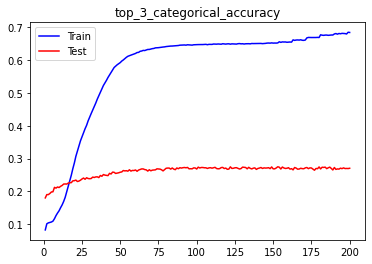

In [38]:
x = [i for i in range(1,201,1)]
for key in keys:
    plt.plot(x, data.history[key], "-b", label="Train")
    plt.plot(x, data.history["val_"+key], "-r", label="Test")
    plt.legend(loc="upper left")
    plt.title(key.split("/")[1])
    break

    

In [31]:
plt.show()

In [34]:
len(train_df.ITEM_ID.unique())

350